# Gradient Descent

## Importing Packages

In [45]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Reading Dataset

In [46]:
#Read CSV data
insuranceData = pd.read_csv('insurance-1.csv')

### Visualizing Dataset Head

In [47]:
insuranceData.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Describing Dataset Information

#### About the Dataset

This dataset represents the attributes of inviduals and the charges the individual must pay for his/her insurance, based on his attributes.
1. Each Feature represents a particular attribute of individuals.
2. Each data-point represents a record of an individual.

In [48]:
insuranceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Describing Dataset Statistics

In [49]:
insuranceData.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Exploratory Data Analysis

### Visualizing Pair-Plots for Features

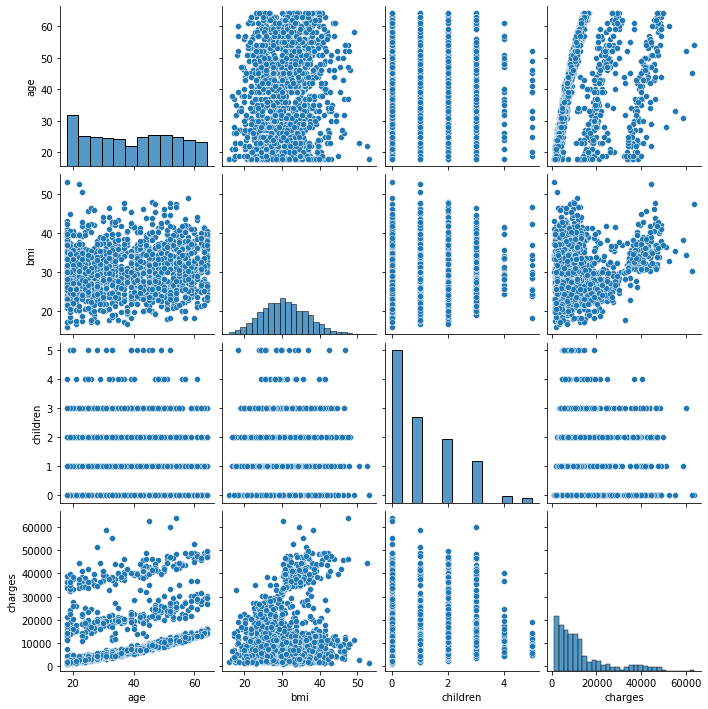

In [50]:
#Check pairplot
sns.pairplot(insuranceData)

### Visualizing Feature Correlation, using Heatmap

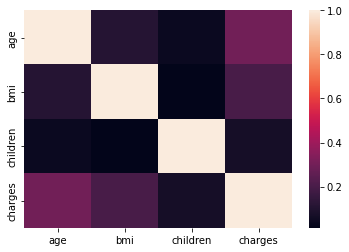

In [51]:
#Check corelation heatmap for numeric features
#1 indicates max corelation
#0 indicates no corelation
dfNum = insuranceData[['age','bmi','children','charges']]
plt.figure()
sns.heatmap(dfNum.corr())

### Eliminating Categorical Features in Dataset

In [52]:
#Eliminate Region from our data
insuranceData.drop('region',axis=1,inplace=True)

### Selecting Features

In [53]:
#Define training features in X
X = insuranceData[['age','sex','bmi','children','smoker']]
#Define output target feature in y
y = insuranceData[['charges']]

## Data Pre-Processing

### Label Encoding

In [54]:
#Transform feature sex by changing female to 0 and male to 1
X['sex'].replace(['female','male'],[0,1],inplace=True)
#Transform feature smoker by changing no to 0 and yes to 1
X['smoker'].replace(['no','yes'],[0,1],inplace=True)
X.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,age,sex,bmi,children,smoker
0,19,0,27.900,0,1
1,18,1,33.770,1,0
2,28,1,33.000,3,0
3,33,1,22.705,0,0
4,32,1,28.880,0,0


### Data Normalization

In [55]:
#Normalize numerical features of X and y 
XN = (X-np.mean(X))/np.std(X)
yN = (y-np.mean(y))/np.std(y)

### Adding Bias

In [56]:
#Add 1s as additional feature called bias in normalized X
XN['bias'] = np.ones(len(yN))

### Visualizing Normalized Dataset Head

In [57]:
#Check head for normalized X
XN.head()

#Check head for normalized y
yN.head()

,charges
0,0.298584
1,-0.953689
2,-0.728675
3,0.719843
4,-0.776802


## Spliting Dataset: Train and Test Datasets

In [58]:
#Split data randomly into Train and Test
X_train, X_test, y_train, y_test = train_test_split(XN, yN, train_size=0.5, random_state=101)

### Spliting Training Dataset into Mini-batches for Mini-Batch GD

In [59]:
#Split the training data into chnks of size of the mini-batch 
mini_batch_size=4
X_train_mini=np.array_split(X_train,mini_batch_size)
Y_train_mini=np.array_split(y_train,mini_batch_size)

## Determining HyperParameter: $α$

This section determines the best value for the hyperparameter $α$ for L2 regularization, using K-Fold Cross-validation

In [60]:
#Function returns best posible alpha for L2 Regularization using KFold
def parameterTuning(X,y):
    
    #Import packages
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import Ridge
    
    #Range of alpha values to check
    alphas = np.linspace(start = 0, stop = 10,num = 50)
    # Start with 50%
    bestAccuracy = 50 
    bestAlpha = 0
    accuracy = 0
    
    #Perform K-Fold cross validation to get the alpha that gives the highest accuracy.
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        kfold = KFold(n_splits=10)
        results = cross_val_score(model,X,y,cv=kfold)
        accuracy = results.mean()*100
        #print(f'Accuracy:{accuracy}')
        if (accuracy >= bestAccuracy):
            bestAccuracy = accuracy
            bestAlpha = alpha
    print(f'Best alpha for L2 Ridge Regularization:{bestAlpha} giving accuracy:{bestAccuracy}')
    return bestAlpha

## Batch Gradient Descent Implementation

### Without Regularization

In [61]:
#Function to calculate and plot Gradient Descent without Regularization
def gradientDescentBatchNR(X_train,y_train,X_test,y_test,eta=0.05,looped=100,acceptableError=0.1):
    print('RUNNING BATCH GRADIENT DESCENT WITHOUT REGULARIZATION ...')
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(y_train)
    #Size of features (including bias) aka Columns
    n=len(X_train.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,6,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Calculate predicted y aka hypothesis
    for loop in range(looped):
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_train,w)
        #Calculate loss in Training data
        loss_train = y_hat - y_train
        #Calculcate cost aka MSE
        cost_train = float((1/m)*(np.sum(loss_train ** 2)))
        #print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Transpose X_train
        X_train_T = X_train.T
        #Calculate Gradient vector
        gradMSEw = (2/m) * (np.dot(X_train_T,loss_train))
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
        #Update weights using Training Rate using eta
        w = w - eta*gradMSEw
        #Check if we have reached the expected
        if (cost_train <= acceptableError):
            break
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')
    #Predict charges by using best weights on both test and train datasets
    y_predicted_test = np.dot(X_test,bestWeights)
    y_predicted_train = np.dot(X_train,bestWeights)
    print('Displaying scatter and line plots for all features ...')
    #Plot for Actual vs Predicted Test Data for all features
    for f in X_test.columns:
        fig = plt.figure(figsize=(8,4),num='BATCH GRADIENT DESCENT')
        plt.subplot(1,2,1)
        plt.title('Regression Line Overlay')
        plt.xlabel(f)
        plt.ylabel('charges')
        plt.plot(X_test[f],y_predicted_test,color='orange',linewidth=1,marker='x',markersize='2',markerfacecolor='green',markeredgewidth=2,markeredgecolor='red', label = 'Predicted Values')
        plt.scatter(X_test[f],y_test,label = 'Actual Values')
        plt.legend()
        plt.subplot(1,2,2)
        plt.title('Scatter Overlay')
        plt.xlabel(f)
        plt.ylabel('charges')
        plt.scatter(X_test[f],y_predicted_test,color='orange',label = 'Predicted Values')
        plt.scatter(X_test[f],y_test,label = 'Actual Values')
        plt.tight_layout()
        plt.legend()
        plt.show()

RUNNING BATCH GRADIENT DESCENT WITHOUT REGULARIZATION ...
Least Cost = 0.2795607735466102 and Best Weights = [[0.25799178]
 [0.00821524]
 [0.18525745]
 [0.04852077]
 [0.79113189]
 [0.00826075]]
Displaying scatter and line plots for all features ...


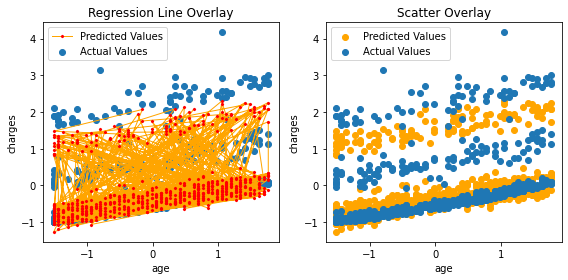

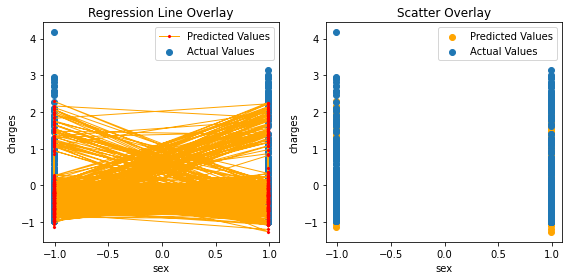

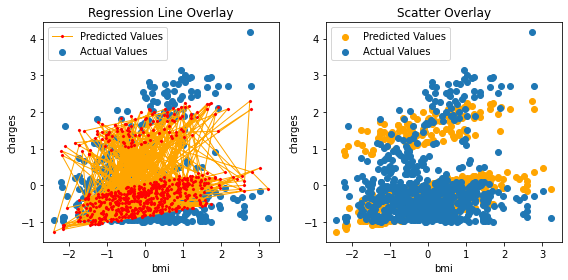

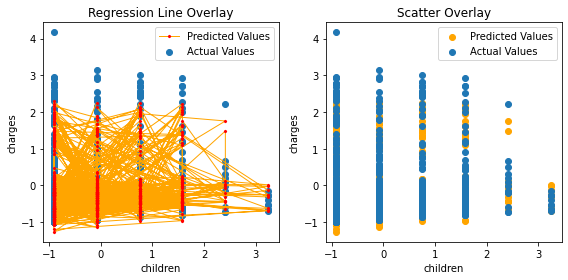

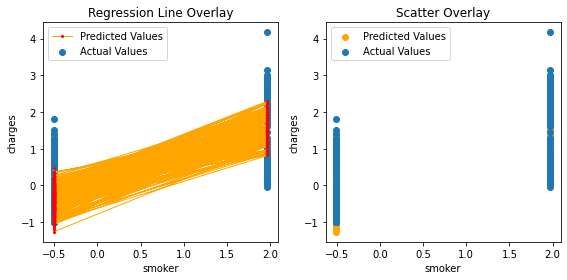

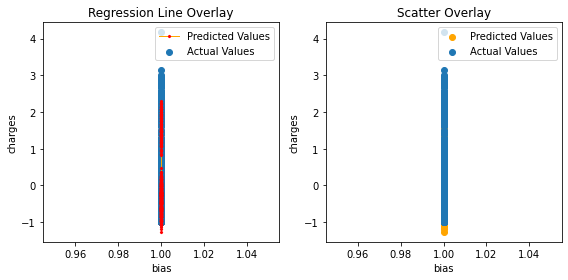

In [62]:
#Call Batch GD without regularization
gradientDescentBatchNR(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),0.05,200,0.1)

### With L1 Regularization

In [63]:
#Function to calculate and plot Gradient Descent with L1 Regularization
def gradientDescentBatchL1(X_train,y_train,X_test,y_test,eta=0.05,looped=100,acceptableError=0.1):
    print('RUNNING BATCH GRADIENT DESCENT WITH L1 REGULARIZATION ...')
    #Set L1 alpha
    alpha = len(X_train.columns) - 1
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(y_train)
    #Size of features (including bias) aka Columns
    n=len(X_train.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,6,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Clculate predicted y aka hypothesis
    for loop in range(looped):
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_train,w)
        #Calculate loss in Training data
        loss_train = y_hat - y_train
        #Calculcate cost aka MSE
        cost_train = float((1/m)*(np.sum(loss_train ** 2)))
        #print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Transpose X_train
        X_train_T = X_train.T
        #Calculate Gradient vector
        gradMSEw = (2/m) * (np.dot(X_train_T,loss_train)) + 2*alpha*np.sign(w)
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
        #Update weights using L1 Regularization (Lasso)
        w = w - eta*gradMSEw
        #Check if we have reached the expected
        if (cost_train <= acceptableError):
            break
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')
    
    #Drop features with weight almost zero from both Training and Test data
    pos = 0
    dropColumns = []
    min_wt = np.min(bestWeights)
    for wt,pos in zip(bestWeights,range(len(bestWeights))):
        if min_wt == wt[0]:
            dropColumns.append(pos)
            print(f'We should drop this feature at position {pos+1} having weight {wt[0]}')
    print(f'Dropping feature at index positions:{dropColumns}')
    print(f'Dropping feature : {X_train.columns[dropColumns]}')
    
    #Dropping Features from Training Data
    X_train.drop(X_train.columns[dropColumns],axis = 1, inplace=True)
    X_test.drop(X_test.columns[dropColumns],axis = 1, inplace=True)
    print(f'Remaining features:{X_train.columns}')
    #Now calling Batch GD after performing L1 regularization
    print(f'Calling Batch GD with reduced features..')
    gradientDescentBatchNR(X_train,y_train,X_test,y_test,eta,looped,acceptableError)

RUNNING BATCH GRADIENT DESCENT WITH L1 REGULARIZATION ...
Least Cost = 0.6331303502183558 and Best Weights = [[ 0.47915875]
 [-0.19588762]
 [-0.1109675 ]
 [-0.19202058]
 [ 0.55847092]
 [ 0.28742024]]
We should drop this feature at position 2 having weight -0.1958876172842563
Dropping feature at index positions:[1]
Dropping feature : Index(['sex'], dtype='object')
Remaining features:Index(['age', 'bmi', 'children', 'smoker', 'bias'], dtype='object')
Calling Batch GD with reduced features..
RUNNING BATCH GRADIENT DESCENT WITHOUT REGULARIZATION ...
Least Cost = 0.27962766830156804 and Best Weights = [[0.25765442]
 [0.18548988]
 [0.04856417]
 [0.79175568]
 [0.00797364]]
Displaying scatter and line plots for all features ...


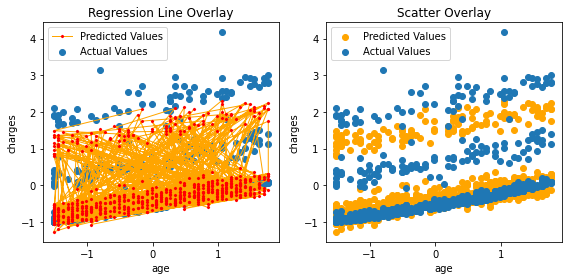

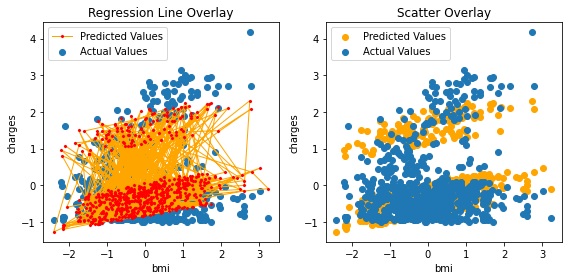

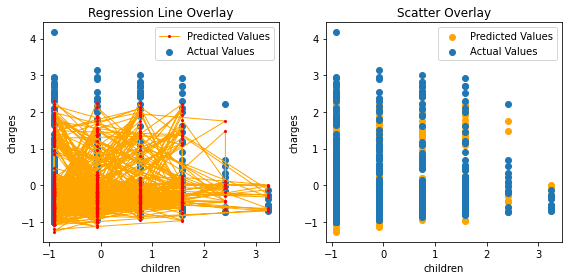

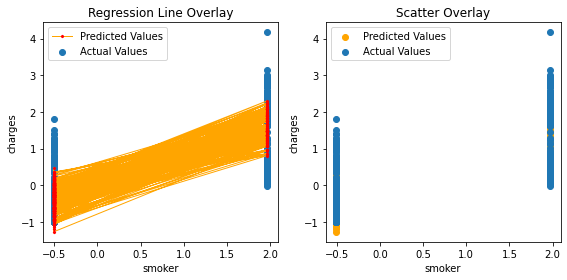

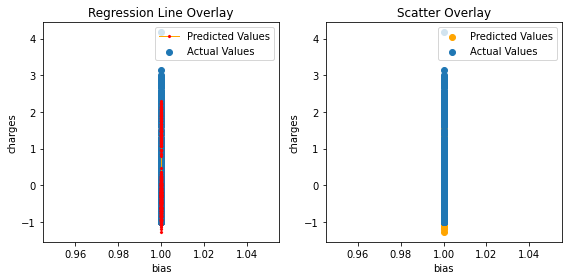

In [64]:
#Call Batch GD with L1 regularization
gradientDescentBatchL1(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),0.05,200,0.1)

### With L2 Regularization

In [65]:
#Function to calculate and plot Gradient Descent with L2 Regularization
def gradientDescentBatchL2(X_train,y_train,X_test,y_test,eta=0.05,looped=100,acceptableError=0.1):
    print('RUNNING BATCH GRADIENT DESCENT WITH L2 REGULARIZATION ...')
    #Get Best alpha for L2 regularization
    alpha = parameterTuning(XN.copy(),yN.copy())
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(y_train)
    #Size of features (including bias) aka Columns
    n=len(X_train.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,6,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Clculate predicted y aka hypothesis
    for loop in range(looped):
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_train,w)
        #Calculate loss in Training data
        loss_train = y_hat - y_train
        #Calculcate cost aka MSE
        cost_train = float((1/m)*(np.sum(loss_train ** 2)))
        # print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Transpose X_train
        X_train_T = X_train.T
        #Calculate Gradient vector
        gradMSEw = (2/m) * (np.dot(X_train_T,loss_train)) + alpha*w
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
        #Update weights using L2 Regularization (Ridge)
        w = w - eta*gradMSEw
        #Check if we have reached the expected
        if (cost_train <= acceptableError):
            break
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')

    #Drop features with weight almost zero from both Training and Test data
    pos = 0
    dropColumns = []
    min_wt = np.min(bestWeights)
    for wt,pos in zip(bestWeights,range(len(bestWeights))):
        if min_wt == wt[0]:
            dropColumns.append(pos)
            print(f'We should drop this feature at position {pos+1} having weight {wt[0]}')
    print(f'Dropping feature at index positions:{dropColumns}')
    print(f'Dropping feature : {X_train.columns[dropColumns]}')
    
    #Dropping Features from Training & Test Data
    X_train.drop(X_train.columns[dropColumns],axis = 1, inplace=True)
    X_test.drop(X_test.columns[dropColumns],axis = 1, inplace=True)
    print(f'Remaining features:{X_train.columns}')
    #Now calling Batch GD after performing L1 regularization
    print(f'Calling Batch GD with reduced features..')
    gradientDescentBatchNR(X_train,y_train,X_test,y_test,eta,looped,acceptableError)

RUNNING BATCH GRADIENT DESCENT WITH L2 REGULARIZATION ...
Best alpha for L2 Ridge Regularization:8.16326530612245 giving accuracy:74.42336297683913
Least Cost = 0.6796589221109727 and Best Weights = [[0.40452243]
 [0.42310922]
 [0.07522886]
 [0.0586382 ]
 [0.34614216]
 [0.18752894]]
We should drop this feature at position 4 having weight 0.05863820419382887
Dropping feature at index positions:[3]
Dropping feature : Index(['children'], dtype='object')
Remaining features:Index(['age', 'sex', 'bmi', 'smoker', 'bias'], dtype='object')
Calling Batch GD with reduced features..
RUNNING BATCH GRADIENT DESCENT WITHOUT REGULARIZATION ...
Least Cost = 0.28189406464236644 and Best Weights = [[0.262762  ]
 [0.00847196]
 [0.18507595]
 [0.79137324]
 [0.01014906]]
Displaying scatter and line plots for all features ...


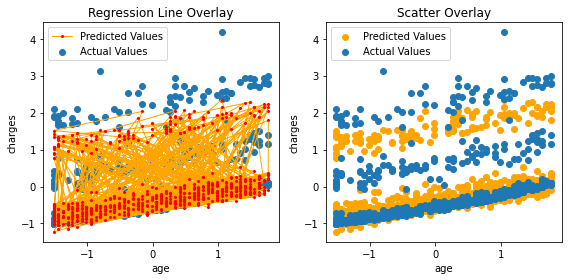

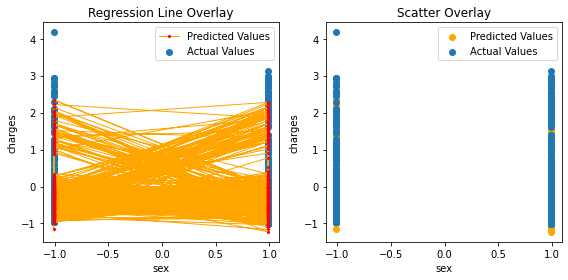

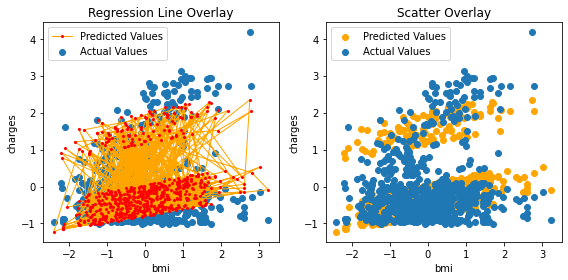

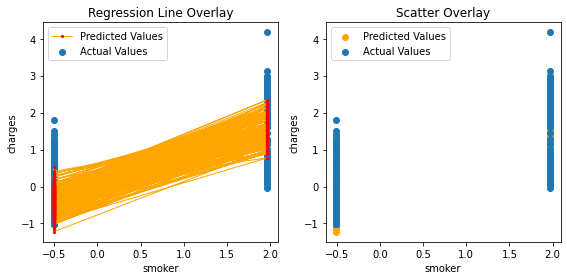

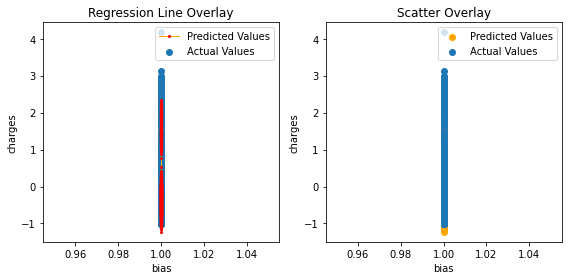

In [66]:
#Call Batch GD with L2 regularization
gradientDescentBatchL2(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),0.07,250,0.1)

## Mini-Batch Gradient Descent Implementation

### Without Regularization

In [67]:
#Function to calculate least cost and best weights for Mini Batch Gradient Descent
def gradientDescentMiniBatchNR(X_train,y_train,eta=0.05,looped=100,acceptableError=0.1):
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(y_train)
    #Size of features (including bias) aka Columns
    n=len(X_train.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,6,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Calculate predicted y aka hypothesis
    for loop in range(looped):
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_train,w)
        #Calculate loss in Training data
        loss_train = y_hat - y_train
        #Calculcate cost aka MSE
        cost_train = float((1/m)*(np.sum(loss_train ** 2)))
        #print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Transpose X_train
        X_train_T = X_train.T
        #Calculate Gradient vector
        gradMSEw = (2/m) * (np.dot(X_train_T,loss_train))
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
        #Update weights using Training Rate using eta
        w = w - eta*gradMSEw
        #Check if we have reached the expected
        if (cost_train <= acceptableError):
            break
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')
    return (leastCost,bestWeights)

In [68]:
def display(X_test,y_test,w):
    print('Displaying scatter and line plots for all features ...')
    #Predict charges by using best weights on test dataset
    y_predicted_test = np.dot(X_test,w)
    for f in X_test.columns:
        fig = plt.figure(figsize=(8,4), num='MINI BATCH GRADIENT DESCENT')
        plt.subplot(1,2,1)
        #Plot for training Data
        plt.title('Regression Line Overlay')
        plt.xlabel(f)
        plt.ylabel('charges')
        plt.plot(X_test[f],y_predicted_test,color='orange',linewidth=1,marker='x',markersize='2',markerfacecolor='green',markeredgewidth=2,markeredgecolor='red', label = 'Predicted Values')
        plt.scatter(X_test[f],y_test,label = 'Actual Values')
        plt.legend()
        #Plot for Test Data
        plt.subplot(1,2,2)
        plt.title('Scatter Overlay')
        plt.xlabel(f)
        plt.ylabel('charges')
        plt.scatter(X_test[f],y_predicted_test,color='orange',label = 'Predicted Values')
        plt.scatter(X_test[f],y_test,label = 'Actual Values')
        plt.tight_layout()
        plt.legend()
        plt.show()

In [69]:
#Call Mini Batch GD without regularization
def Mini_Batch_GD(X_train_mini,Y_train_mini,X_test,y_test):
    print('RUNNING MINI BATCH GRADIENT DESCENT WITHOUT REGULARIZATION ...')
    leastCost_sum=0
    w_sum=0
    for i in range(len(X_train_mini)):
        print(f'Calling Mini Batch for set {i+1}')
        leastCost_mini,w_mini=gradientDescentMiniBatchNR(X_train_mini[i],Y_train_mini[i],0.05,200,0.1)
        leastCost_sum+=leastCost_mini
        w_sum+=w_mini
    #Show the average least Cost and Best Weight
    w = w_sum/mini_batch_size
    avgCost = leastCost_sum/mini_batch_size
    print(f'Average Least Cost = {avgCost} and Average Best Weights = {w}')
    #Display predictions using avergae weights
    print(f'Predicting target using best average weights')
    display(X_test,y_test,w)

RUNNING MINI BATCH GRADIENT DESCENT WITHOUT REGULARIZATION ...
Calling Mini Batch for set 1
Least Cost = 0.2597457433207866 and Best Weights = [[ 0.25281849]
 [-0.02410274]
 [ 0.17402339]
 [ 0.04024759]
 [ 0.84337398]
 [ 0.0430442 ]]
Calling Mini Batch for set 2
Least Cost = 0.28999936890026834 and Best Weights = [[ 2.40448738e-01]
 [-6.04671656e-04]
 [ 1.37527534e-01]
 [ 1.06169167e-01]
 [ 7.84803575e-01]
 [-1.06896095e-03]]
Calling Mini Batch for set 3
Least Cost = 0.24618957586856194 and Best Weights = [[ 0.27371675]
 [ 0.06509841]
 [ 0.22993868]
 [ 0.08422628]
 [ 0.77366502]
 [-0.02939469]]
Calling Mini Batch for set 4
Least Cost = 0.2960737362459258 and Best Weights = [[ 0.25698875]
 [ 0.00179244]
 [ 0.20131421]
 [-0.0298594 ]
 [ 0.77567827]
 [ 0.00905301]]
Average Least Cost = 0.27300210608388564 and Average Best Weights = [[0.25599318]
 [0.01054586]
 [0.18570096]
 [0.05019591]
 [0.79438021]
 [0.00540839]]
Predicting target using best average weights
Displaying scatter and line p

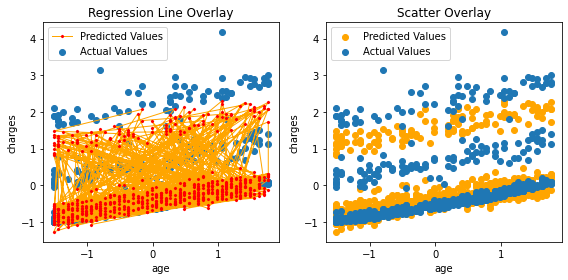

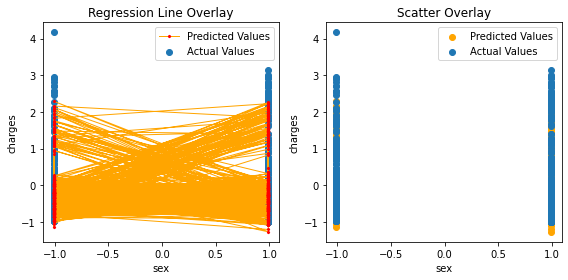

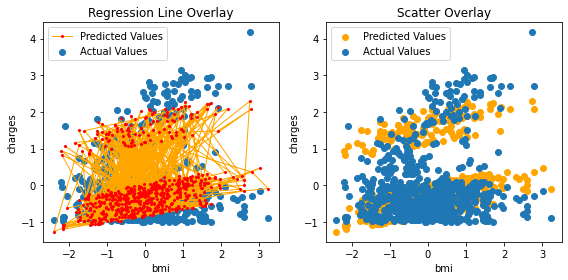

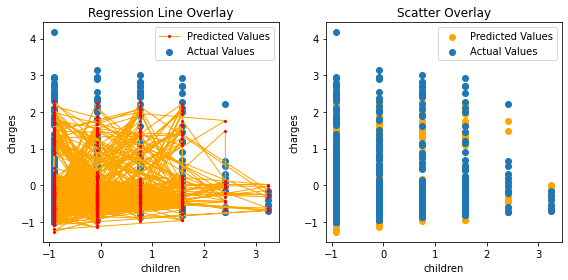

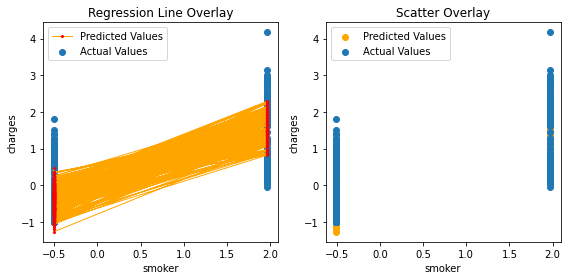

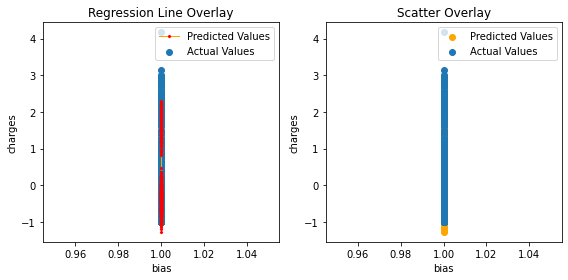

In [70]:
#Call Mini Batch without regularization
Mini_Batch_GD(X_train_mini.copy(),Y_train_mini.copy(),X_test.copy(),y_test.copy())

### With L1 Regularization

In [71]:
#Function to calculate and plot Mini Batch Gradient Descent with L1 Regularization
def gradientDescentMiniBatchL1(X_train_mini_L1,Y_train_mini_L1,eta=0.05,looped=100,acceptableError=0.1,alpha = 5):
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(Y_train_mini_L1)
    #Size of features (including bias) aka Columns
    n=len(X_train_mini_L1.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,6,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Clculate predicted y aka hypothesis
    for loop in range(looped):
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_train_mini_L1,w)
        #Calculate loss in Training data
        loss_train = y_hat - Y_train_mini_L1
        #Calculcate cost aka MSE
        cost_train = float((1/m)*(np.sum(loss_train ** 2)))
        #print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Transpose X_train
        X_train_mini_L1_T = X_train_mini_L1.T
        #Calculate Gradient vector
        gradMSEw = (2/m) * (np.dot(X_train_mini_L1_T,loss_train)) + 2*alpha*np.sign(w)
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
        #Update weights using L1 Regularization (Lasso)
        w = w - eta*gradMSEw
        #Check if we have reached the expected
        if (cost_train <= acceptableError):
            break
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')
    return (leastCost,bestWeights)

In [72]:
#Function for Mini Batch L1
def Mini_Batch_L1(X_train_mini_L1,Y_train_mini_L1,X_test_L1,y_test_L1):
    print('RUNNING MINI BATCH GRADIENT DESCENT WITH L1 REGULARIZATION ...')
    #Call Mini Batch GD with L1 regularization
    leastCost_sum=0
    w_sum=0
    #Set L1 alpha to number of features excluding bias
    alpha = len(X_test.columns) - 1
    for i in range(len(X_train_mini_L1)):
        print(f'Calling Mini Batch GD with L1 regularization for set {i+1}')
        leastCost_mini,w_mini=gradientDescentMiniBatchL1(X_train_mini_L1[i],Y_train_mini[i],0.05,200,0.1,alpha)
        leastCost_sum+=leastCost_mini
        w_sum+=w_mini
    
    w = w_sum/mini_batch_size
    avgCost = leastCost_sum/mini_batch_size
    #Show the average least Cost and Best Weight
    print(f'Before feature reduction Average Least Cost = {avgCost} and Average Best Weights = {w}')
    
    #Drop feature with least weight from both Training and Test data
    pos = 0
    dropColumns = []
    min_wt = np.min(w)
    for wt,pos in zip(w,range(len(w))):
        if min_wt == wt[0]:
            dropColumns.append(pos)
            print(f'We should drop this feature at position {pos+1} having weight {wt[0]}')
    print(f'Dropping feature at index positions:{dropColumns}')
    print(f'Dropping feature : {X_train_mini_L1[0].columns[dropColumns]}')
    
    #Dropping Features from Training & Test Data
    for i in range(len(X_train_mini_L1)):
        X_train_mini_L1[i].drop(X_train_mini_L1[i].columns[dropColumns],axis = 1, inplace=True)
    print(f'Remaining features:{X_train_mini_L1[0].columns}')
    X_test_L1.drop(X_test_L1.columns[dropColumns],axis = 1, inplace=True)

    #Now calling Mini Batch GD after performing L1 regularization
    print(f'Calling Mini Batch Gradient Descent after L1 regularization ...')
    Mini_Batch_GD(X_train_mini_L1,Y_train_mini_L1,X_test_L1,y_test_L1)

RUNNING MINI BATCH GRADIENT DESCENT WITH L1 REGULARIZATION ...
Calling Mini Batch GD with L1 regularization for set 1
Least Cost = 0.6605894157618719 and Best Weights = [[ 0.42503265]
 [ 0.25093513]
 [ 0.4100542 ]
 [-0.17339906]
 [ 0.48239844]
 [-0.17830948]]
Calling Mini Batch GD with L1 regularization for set 2
Least Cost = 0.6708809157823489 and Best Weights = [[ 0.47296471]
 [-0.1620833 ]
 [-0.16315427]
 [-0.16892704]
 [ 0.49029756]
 [-0.2564458 ]]
Calling Mini Batch GD with L1 regularization for set 3
Least Cost = 0.4812568011519257 and Best Weights = [[ 0.44713605]
 [ 0.37776877]
 [ 0.18981385]
 [ 0.26638678]
 [ 0.58027427]
 [-0.22892571]]
Calling Mini Batch GD with L1 regularization for set 4
Least Cost = 0.596322679469972 and Best Weights = [[ 0.49858008]
 [ 0.37216499]
 [ 0.16959097]
 [-0.13777006]
 [ 0.48712738]
 [ 0.20317017]]
Before feature reduction Average Least Cost = 0.6022624530415297 and Average Best Weights = [[ 0.46092837]
 [ 0.2096964 ]
 [ 0.15157618]
 [-0.05342734

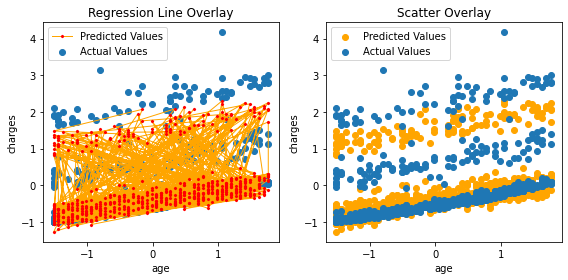

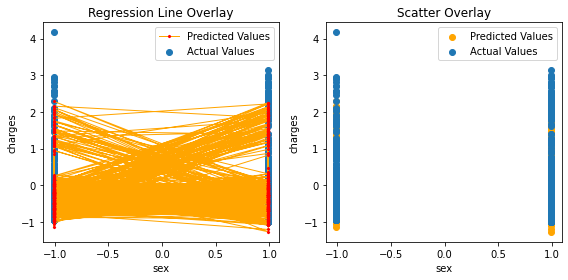

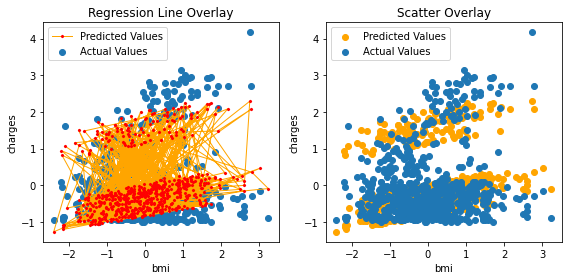

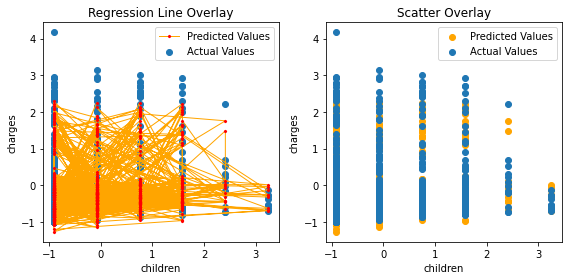

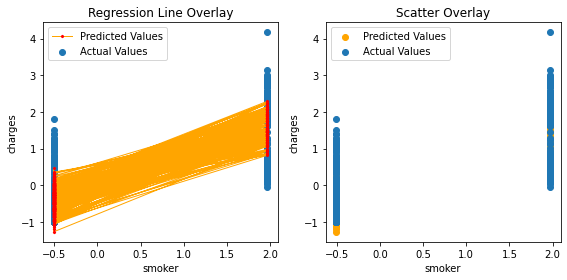

In [73]:
#Call Mini Batch L1
Mini_Batch_L1(X_train_mini.copy(),Y_train_mini.copy(),X_test.copy(),y_test.copy())

### With L2 Regularization

In [74]:
#Function to calculate and plot Mini Batch Gradient Descent with L2 Regularization
def gradientDescentMiniBatchL2(X_train_mini_L2,Y_train_mini_L2,eta=0.05,looped=100,acceptableError=0.1,alpha=5):
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(Y_train_mini_L2)
    #Size of features (including bias) aka Columns
    n=len(X_train_mini_L2.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,6,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Clculate predicted y aka hypothesis
    for loop in range(looped):
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_train_mini_L2,w)
        #Calculate loss in Training data
        loss_train = y_hat - Y_train_mini_L2
        #Calculcate cost aka MSE
        cost_train = float((1/m)*(np.sum(loss_train ** 2)))
        # print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Transpose X_train
        X_train_mini_L2_T = X_train_mini_L2.T
        #Calculate Gradient vector
        gradMSEw = (2/m) * (np.dot(X_train_mini_L2_T,loss_train)) + alpha*w
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
        #Update weights using L2 Regularization (Ridge)
        w = w - eta*gradMSEw
        #Check if we have reached the expected
        if (cost_train <= acceptableError):
            break
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')
    return (leastCost,bestWeights)

In [75]:
#Function for Mini Batch L2
def Mini_Batch_L2(X_train_mini_L2,Y_train_mini_L2,X_test_L2,y_test_L2):
    print('RUNNING MINI BATCH GRADIENT DESCENT WITH L2 REGULARIZATION ...')
    #Get Best alpha for Mini Batch L2 regularization
    alpha= [None]*len(X_train_mini_L2) 
    leastCost_sum_L2=0
    w_sum_L2=0
    #Get L2 alpha from KFold
    for i in range(len(X_train_mini_L2)):
        alpha[i] = parameterTuning(X_train_mini_L2[i],Y_train_mini_L2[i])
        #Call Mini Batch GD with L2 regularization
        print(f'Calling Mini Batch GD with L2 regularization for set {i+1}')
        leastCost_l2_mini,w_l2_mini=gradientDescentMiniBatchL2(X_train_mini_L2[i],Y_train_mini_L2[i],0.07,250,0.1,alpha[i])
        leastCost_sum_L2+=leastCost_l2_mini
        w_sum_L2+=w_l2_mini
    
    #Show the average least Cost and Best Weight
    w = w_sum_L2/mini_batch_size
    avgCost = leastCost_sum_L2/mini_batch_size
    #Show the average least Cost and Best Weight
    print(f'Before feature reduction Average Least Cost = {avgCost} and Average Best Weights = {w}')
    
    #Drop feature with least weight from both Training and Test data
    pos = 0
    dropColumns = []
    min_wt = np.min(w)
    for wt,pos in zip(w,range(len(w))):
        if min_wt == wt[0]:
            dropColumns.append(pos)
            print(f'We should drop this feature at position {pos+1} having weight {wt[0]}')
    print(f'Dropping feature at index positions:{dropColumns}')
    print(f'Dropping feature : {X_train_mini_L2[0].columns[dropColumns]}')
    
    #Dropping Features from Training Data
    for i in range(len(X_train_mini)):
        X_train_mini_L2[i].drop(X_train_mini_L2[i].columns[dropColumns],axis = 1, inplace=True)
    print(f'Remaining features:{X_train_mini_L2[0].columns}')
    X_test_L2.drop(X_test_L2.columns[dropColumns],axis = 1, inplace=True)

    #Now calling Batch GD after performing L2 regularization
    print(f'Calling Mini Batch Gradient Descent after L2 regularization ...')
    Mini_Batch_GD(X_train_mini_L2,Y_train_mini_L2,X_test_L2,y_test_L2)

RUNNING MINI BATCH GRADIENT DESCENT WITH L2 REGULARIZATION ...
Best alpha for L2 Ridge Regularization:2.4489795918367347 giving accuracy:74.10305612462847
Calling Mini Batch GD with L2 regularization for set 1
Least Cost = 0.45980370700827355 and Best Weights = [[0.19222093]
 [0.12861329]
 [0.1842202 ]
 [0.19723364]
 [0.4712365 ]
 [0.12412009]]
Best alpha for L2 Ridge Regularization:8.571428571428571 giving accuracy:64.57336311284591
Calling Mini Batch GD with L2 regularization for set 2
Least Cost = 0.4400724653336707 and Best Weights = [[ 0.31802732]
 [ 0.19824927]
 [ 0.0924573 ]
 [-0.01489631]
 [ 0.45924803]
 [ 0.09126559]]
Best alpha for L2 Ridge Regularization:10.0 giving accuracy:67.43157114187248
Calling Mini Batch GD with L2 regularization for set 3
Least Cost = 0.7353188282354152 and Best Weights = [[0.14495682]
 [0.04503588]
 [0.14151128]
 [0.00972739]
 [0.13642716]
 [0.07692184]]
Best alpha for L2 Ridge Regularization:9.387755102040817 giving accuracy:67.28505336286736
Calli

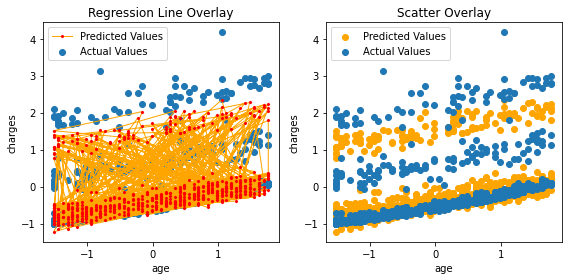

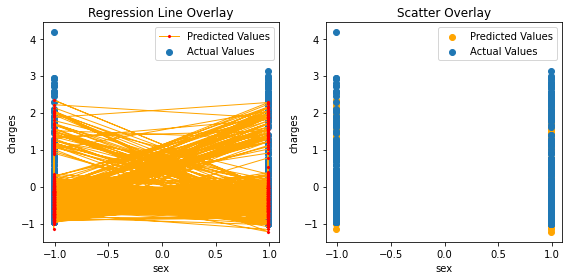

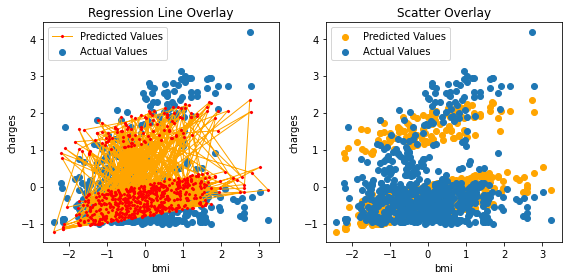

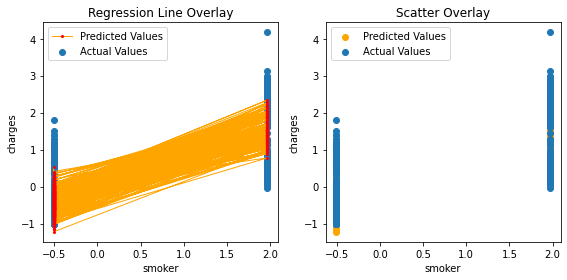

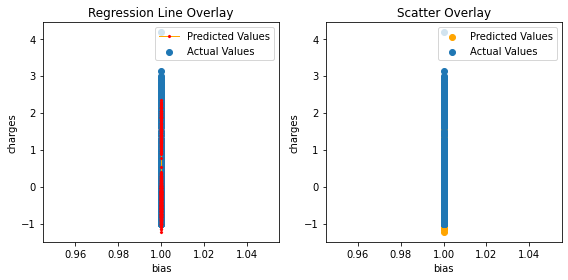

In [76]:
#Call Mini Batch L2
Mini_Batch_L2(X_train_mini.copy(),Y_train_mini.copy(),X_test.copy(),y_test.copy())

## Stochastic Gradient Descent Implementation

### Without Regularization

In [77]:
#Function to calculate and plot Stochastic Gradient Descent without Regularization
def gradientDescentStochasticNR(X_train,y_train, X_test, y_test,eta=0.05,steps=100):
    print('RUNNING STOCHASTIC GRADIENT DESCENT WITHOUT REGULARIZATION ...')
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(y_train)
    #Size of features (including bias) aka Columns
    n=len(X_train.columns)
    #Define Weight Matrix and randomly initialize it
    w=np.random.randint(0,10,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Calculate predicted y aka hypothesis
    for loop in range(steps):
        # rand_instance = np.random.randint(0, m)
        #Taking Instance of Training set
        X_rand = X_train.iloc[loop].to_frame()
        Y_rand = y_train.iloc[loop].to_frame()
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_rand.T,w)
        #Calculate loss in Training data
        loss_train = y_hat - Y_rand
        #Calculcate cost aka MSE
        cost_train = float(np.sum(loss_train ** 2))
        #print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Transpose X_train
        #Calculate Gradient vector
        gradMSEw = (2) * (np.dot(X_rand,loss_train))
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
            eta = eta/1.02 #Add learning decay

        #Update weights using Training Rate using eta
        w = w - eta*gradMSEw
        
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')

    #Predict charges by using best weights on both test and train datasets
    y_predicted_test = np.dot(X_test,bestWeights)
    y_predicted_train = np.dot(X_train,bestWeights)
    #Plot for Actual vs Predicted Test Data for all features
    print('Displaying scatter and line plots for all features ...')
    for f in X_test.columns:
        fig = plt.figure(figsize=(8,4),num='STOCHASTIC GRADIENT DESCENT')
        plt.subplot(1,2,1)
        plt.title('Regression Line Overlay')
        plt.xlabel(f)
        plt.ylabel('charges')
        plt.plot(X_test[f],y_predicted_test,color='orange',linewidth=1,marker='x',markersize='2',markerfacecolor='green',markeredgewidth=2,markeredgecolor='red', label = 'Predicted Values')
        plt.scatter(X_test[f],y_test,label = 'Actual Values')
        plt.legend()
        plt.subplot(1,2,2)
        plt.title('Scatter Overlay')
        plt.xlabel(f)
        plt.ylabel('charges')
        plt.scatter(X_test[f],y_predicted_test,color='orange',label = 'Predicted Values')
        plt.scatter(X_test[f],y_test,label = 'Actual Values')
        plt.tight_layout()
        plt.legend()
        plt.show()

RUNNING STOCHASTIC GRADIENT DESCENT WITHOUT REGULARIZATION ...
Least Cost = 1.578175548528245e-06 and Best Weights = [[ 0.47078185]
 [ 1.29545368]
 [-1.05787328]
 [-0.21250964]
 [-0.98603261]
 [-0.22048591]]
Displaying scatter and line plots for all features ...


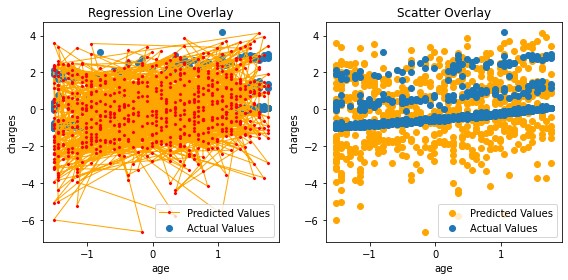

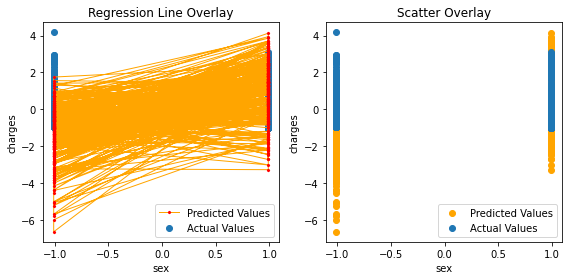

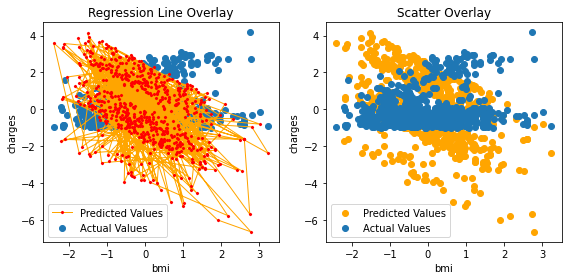

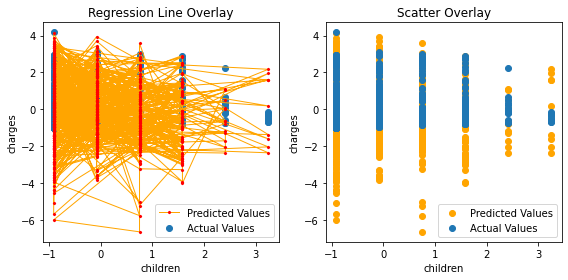

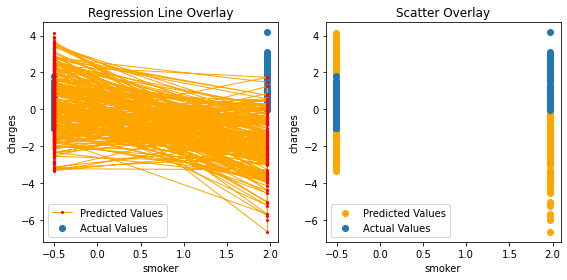

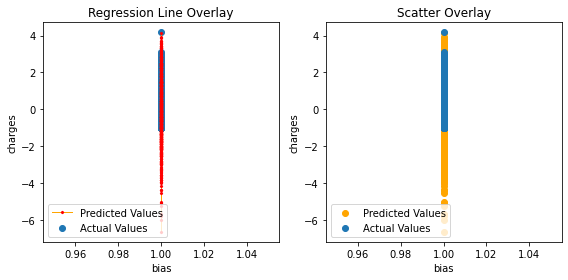

In [78]:
#Call Stochastic GD without regularization
gradientDescentStochasticNR(X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy(),0.1,100)

### With L1 Regularization

In [79]:
#Function to calculate and plot Gradient Descent without Regularization
def gradientDescentStochasticL1(X_train, y_train, X_test, y_test,eta=0.05,looped=100):
    print('RUNNING STOCHASTIC GRADIENT DESCENT WITH L1 REGULARIZATION ...')
    #Set alpha to non bias feature count
    alpha = len(X_train.columns) - 1
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(y_train)
    #Size of features (including bias) aka Columns
    n=len(X_train.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,10,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Clculate predicted y aka hypothesis
    for loop in range(looped):
        #Taking Instance of Training set
        X_rand = X_train.iloc[loop].to_frame()
        Y_rand = y_train.iloc[loop].to_frame()
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_rand.T,w)
        #Calculate loss in Training data
        loss_train = y_hat - Y_rand
        #Calculcate cost aka MSE
        cost_train = float(np.sum(loss_train ** 2))
        #print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Calculate least cost and update bestWeights
        gradMSEw = 2*(np.dot(X_rand,loss_train)) + 2*alpha*np.sign(w)
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
            eta = eta/1.02 #Add learning decay
        #Update weights using L1 Regularization (Lasso)
        w = w - eta*gradMSEw
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')
    #Drop features with weight almost zero from both Training data
    dropColumns = []
    min_wt = np.min(bestWeights)
    for wt,pos in zip(bestWeights,range(len(bestWeights))):
        if min_wt == wt[0]:
            dropColumns.append(pos)
            print(f'We should drop this feature at position {pos+1} having weight {wt[0]}')
    print(f'Dropping feature at index positions:{dropColumns}')
    print(f'Dropping feature : {X_train.columns[dropColumns]}')
    #Dropping Features from Training Data
    X_train.drop(X_train.columns[dropColumns],axis = 1, inplace=True)
    X_test.drop(X_test.columns[dropColumns],axis = 1, inplace=True)
    print(f'Remaining features:{X_train.columns}')
    print(f'Calling Stochastic Gradient Descent after L1 regularization ...')
    #Now calling Stochastic GD after performing L1 regularization
    gradientDescentStochasticNR(X_train,y_train,X_test,y_test,eta,looped)

RUNNING STOCHASTIC GRADIENT DESCENT WITH L1 REGULARIZATION ...
Least Cost = 3.820095859127778e-05 and Best Weights = [[ 0.0523648 ]
 [ 0.06778072]
 [-0.05321362]
 [ 0.03402059]
 [ 0.04731078]
 [ 0.00164046]]
We should drop this feature at position 3 having weight -0.05321362119892564
Dropping feature at index positions:[2]
Dropping feature : Index(['bmi'], dtype='object')
Remaining features:Index(['age', 'sex', 'children', 'smoker', 'bias'], dtype='object')
Calling Stochastic Gradient Descent after L1 regularization ...
RUNNING STOCHASTIC GRADIENT DESCENT WITHOUT REGULARIZATION ...
Least Cost = 1.8066751734791234e-08 and Best Weights = [[0.25492446]
 [0.43392668]
 [0.92691175]
 [0.91513968]
 [1.13948417]]
Displaying scatter and line plots for all features ...


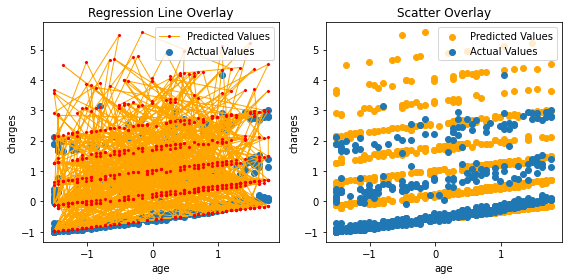

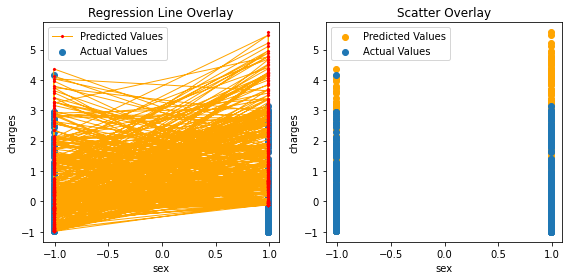

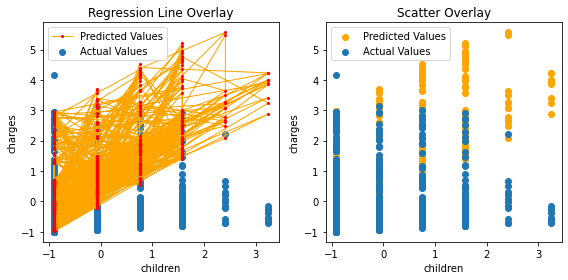

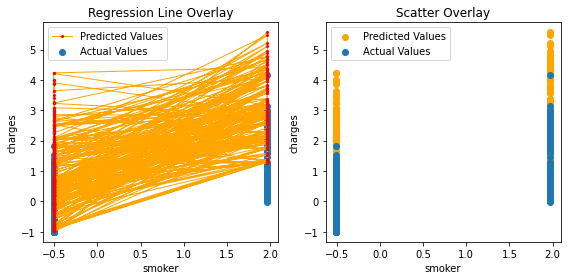

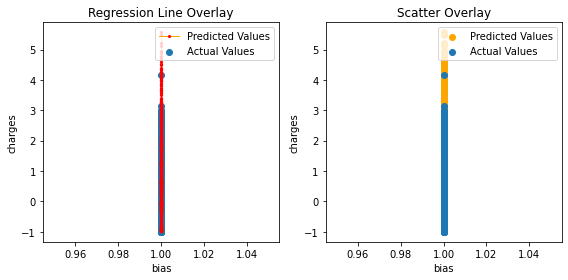

In [80]:
#Call Stochastic L1 GD
gradientDescentStochasticL1(X_train.copy(),y_train.copy(), X_test.copy(), y_test.copy(),0.01,200)

### With L2 Regularization

In [81]:
#Function to calculate and plot Gradient Descent with L2 Regularization
def gradientDescentStochasticL2(X_train,y_train,X_test,y_test,eta=0.05,looped=100):
    print('RUNNING STOCHASTIC GRADIENT DESCENT WITH L2 REGULARIZATION ...')
    #Get Best alpha for L2 regularization
    alpha = parameterTuning(XN.copy(),yN.copy())
    #Least Cost
    leastCost = 1000
    #MSE aka cost
    MSE_train = []
    #Size of training set aka Rows
    m=len(y_train)
    #Size of features (including bias) aka Columns
    n=len(X_train.columns)
    #Define Weight Matrix and randomly initliaze it
    w=np.random.randint(0,6,n).reshape(n,1)
    #Best Weights
    bestWeights = w
    #Clculate predicted y aka hypothesis
    for loop in range(looped):
        #Taking Instance of Training set
        X_rand = X_train.iloc[loop].to_frame()
        Y_rand = y_train.iloc[loop].to_frame()
        #Calculate hypothesis/predicted values
        y_hat = np.dot(X_rand.T,w)
        #Calculate loss in Training data
        loss_train = y_hat - Y_rand
        #Calculcate cost aka MSE
        cost_train = float(np.sum(loss_train ** 2))
        #print(f'Loop:{loop+1} => Cost:{cost_train}')
        # MSE list
        MSE_train.append(cost_train) 
        #Calculate Gradient Vector
        gradMSEw = 2*(np.dot(X_rand,loss_train)) + alpha*w
        #Calculate least cost and update bestWeights
        if(cost_train <= leastCost):
            leastCost = cost_train
            bestWeights = w
            eta = eta/1.02 #Add learning decay
        #Update weights using L2 Regularization (Ridge)
        w = w - eta*gradMSEw
    #Show least Cost and Best Weight
    print(f'Least Cost = {leastCost} and Best Weights = {bestWeights}')
    #Drop features with weight almost zero from both Training data
    dropColumns = []
    min_wt = np.min(bestWeights)
    for wt,pos in zip(bestWeights,range(len(bestWeights))):
        if min_wt == wt[0]:
            dropColumns.append(pos)
            print(f'We should drop this feature at position {pos+1} having weight {wt[0]}')
    print(f'Dropping feature at index positions:{dropColumns}')
    print(f'Dropping feature : {X_train.columns[dropColumns]}')
    #Dropping Features from Training & Test Data
    X_train.drop(X_train.columns[dropColumns],axis = 1, inplace=True)
    X_test.drop(X_test.columns[dropColumns],axis = 1, inplace=True)
    print(f'Remaining features:{X_train.columns}')
    #Now calling Batch GD after performing L2 regularization
    print(f'Calling Stochastic Gradient Descent after L2 regularization ...')
    gradientDescentStochasticNR(X_train,y_train,X_test,y_test,eta,looped)

RUNNING STOCHASTIC GRADIENT DESCENT WITH L2 REGULARIZATION ...
Best alpha for L2 Ridge Regularization:8.16326530612245 giving accuracy:74.42336297683913
Least Cost = 1.917990512238079e-08 and Best Weights = [[-0.00750303]
 [-0.03318718]
 [ 0.01647579]
 [-0.03419783]
 [ 0.02005638]
 [-0.03948486]]
We should drop this feature at position 6 having weight -0.03948486012866061
Dropping feature at index positions:[5]
Dropping feature : Index(['bias'], dtype='object')
Remaining features:Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')
Calling Stochastic Gradient Descent after L2 regularization ...
RUNNING STOCHASTIC GRADIENT DESCENT WITHOUT REGULARIZATION ...
Least Cost = 3.969286803387707e-07 and Best Weights = [[ 0.46492755]
 [-0.02885094]
 [ 0.2215102 ]
 [-0.13951463]
 [ 0.87890351]]
Displaying scatter and line plots for all features ...


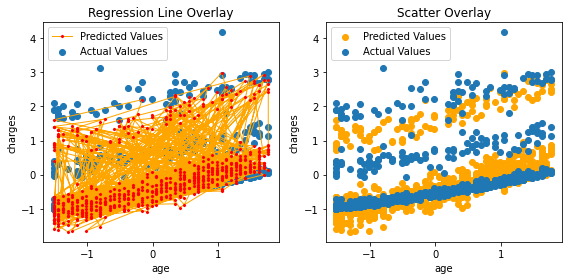

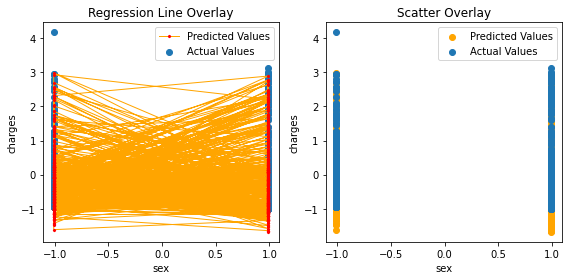

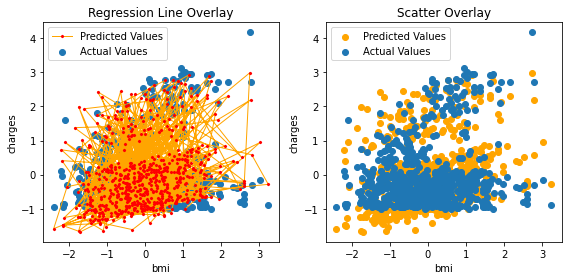

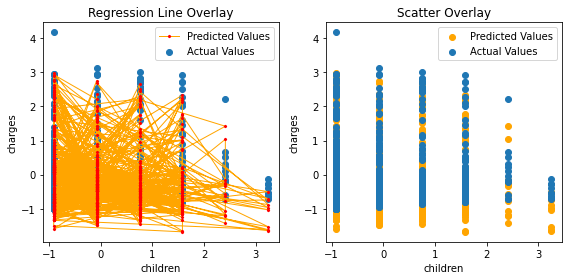

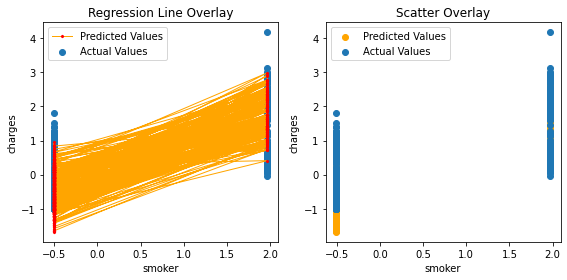

In [82]:
#Call Stochastic GD with L2 regularization
gradientDescentStochasticL2(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),0.07,250)